# Experiment Analysis

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import numpy as np
import pandas as pd
import plotly.graph_objects as go

from htc.evaluation.analyze_tfevents import read_tfevent_losses
from htc.evaluation.metrics.scores import normalize_grouped_cm
from htc.settings import settings
from htc.tissue_atlas.MetricAggregationClassification import MetricAggregationClassification
from htc.tissue_atlas.settings_atlas import settings_atlas
from htc.utils.Config import Config
from htc.utils.helper_functions import sort_labels
from htc.utils.LabelMapping import LabelMapping
from htc.utils.visualization import create_confusion_figure, show_loss_chart, show_utilization, visualize_dict

In [2]:
# Parameter for papermill
run_dir = settings.training_dir / "median_pixel" / settings_atlas.best_run

In [3]:
assert run_dir != "", "No run_dir specified"
if type(run_dir) == str:
    run_dir = Path(run_dir)
print(f"Model: {run_dir.parent.name}")
print(f"Experiment: {run_dir.name}")

Model: median_pixel
Experiment: 2021-07-31_03-46-04_generated_default_lr=0.0001,gamma=0.9,dropout=0.2,class_weight_method=softmin,oversampling=False,batch_size=20000


In [4]:
config = Config(run_dir / "config.json")
mapping = LabelMapping.from_config(config)
visualize_dict(config.data)

## Training

In [5]:
df_train = read_tfevent_losses(run_dir)
df_train.head()

,fold_name,epoch_index,step,lr-Adam,train/ce_loss_step,accuracy,train/ce_loss_epoch
0,fold_P041,0,0,0.0001,NaN,NaN,NaN
1,fold_P041,0,49,NaN,2.164146,NaN,NaN
2,fold_P041,0,99,NaN,1.853330,NaN,NaN
3,fold_P041,0,149,NaN,1.591656,NaN,NaN
4,fold_P041,0,199,NaN,1.401316,NaN,NaN


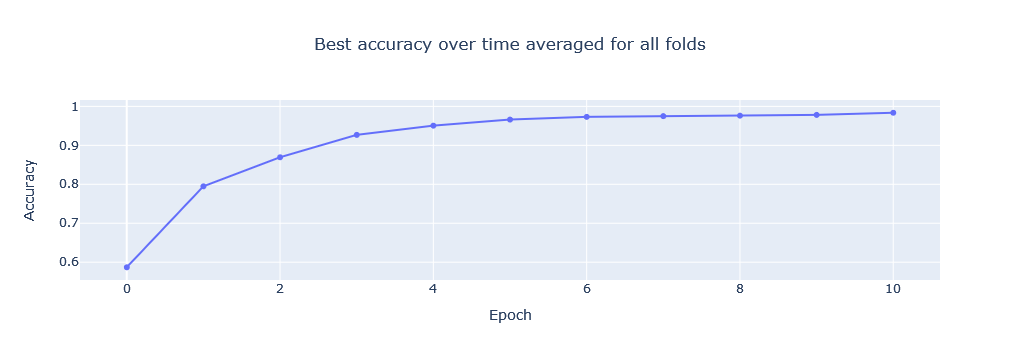

In [6]:
all_folds = df_train["fold_name"].unique()
accuracies = np.zeros((len(all_folds), df_train["epoch_index"].max() + 1))

for f, fold in enumerate(all_folds):
    df_fold = df_train.query("fold_name == @fold")
    acc = df_fold["accuracy"].values
    acc = acc[~np.isnan(acc)]
    assert len(acc) == accuracies.shape[1], len(acc)

    for a, acc_value in enumerate(acc):
        if a == 0 or acc_value > accuracies[f, a - 1]:
            accuracies[f, a] = acc_value
        else:
            accuracies[f, a] = accuracies[f, a - 1]

fig = go.Figure()
fig.add_trace(go.Scatter(y=np.mean(accuracies, axis=0)))
fig.update_layout(title_x=0.5, title_text="Best accuracy over time averaged for all folds")
fig.update_layout(xaxis_title="Epoch", yaxis_title="Accuracy")

[WARNING][htc] No GPU with a utilization of at least 0.1 found                                   helper_functions.py:188
(log_path=/mnt/E130-Projekte/Biophotonics/Projects/2021_02_05_hyperspectral_tissue_classificatio                        
n/results_tissue_atlas/training/median_pixel/2021-07-31_03-46-04_generated_default_lr=0.0001,gam                        
ma=0.9,dropout=0.2,class_weight_method=softmin,oversampling=False,batch_size=20000/fold_P094/sys                        
tem_log_2021-07-31_08-25-37.json, all_gpus_load=[0.])                                                                   

[WARNING][py.warnings]                                                                                   warnings.py:109
/home/j562r/miniconda3/envs/htc/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432:                             
RuntimeWarning:                                                                                                         
                                                                                                                        
Mean of empty slice.                                                                                                    
                                                                                                                        
                                                                                                                        

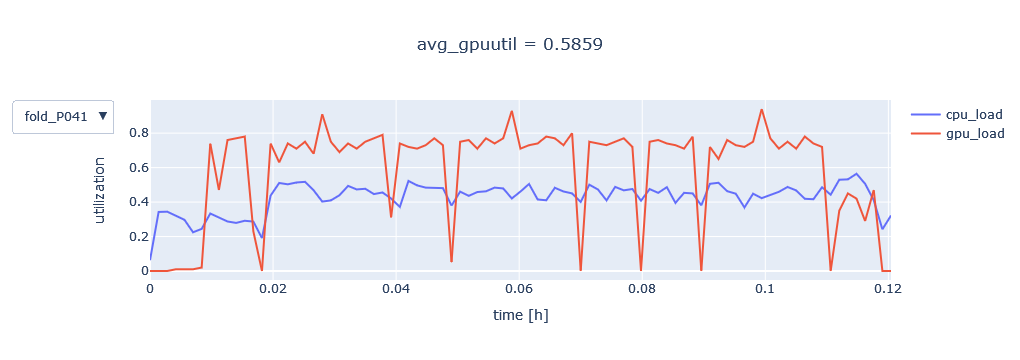

In [7]:
show_utilization(run_dir)

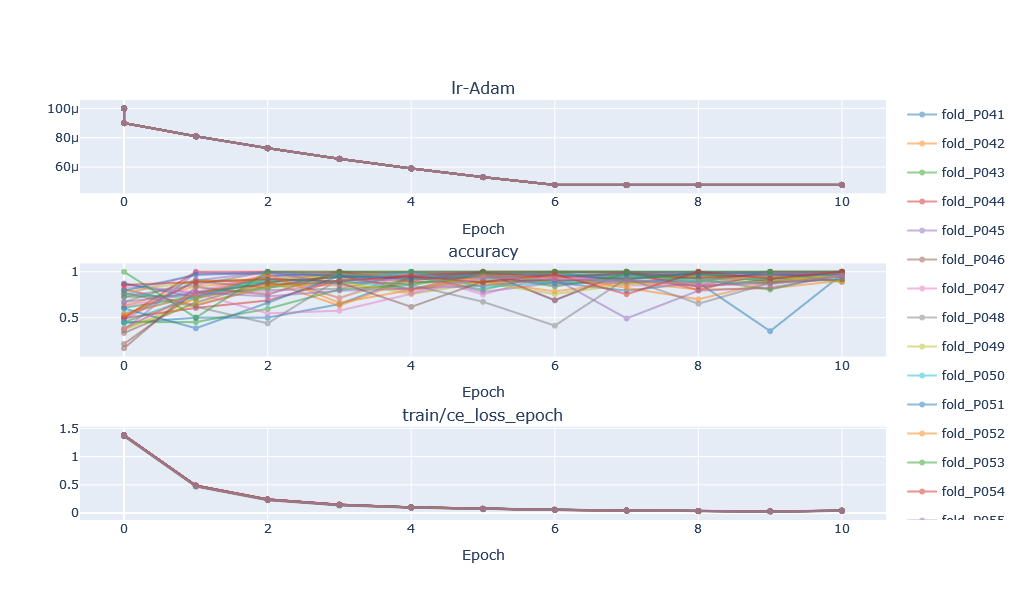

In [8]:
show_loss_chart(df_train)

## Validation

In [9]:
df_val = (
    pd.read_pickle(run_dir / "validation_table.pkl.xz")
    .query("dataset_index == 0 and epoch_index == best_epoch_index")
    .rename(columns={"image_name": "subject_name"})
)
df_val.sort_values(["accuracy"])

,epoch_index,best_epoch_index,dataset_index,fold_name,subject_name,accuracy,confusion_matrix
241,10,10,0,fold_P062,P062,0.903010,"[[16, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
395,10,10,0,fold_P088,P088,0.916147,"[[36, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
417,10,10,0,fold_P094,P094,0.948899,"[[51, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0..."
384,10,10,0,fold_P085,P085,0.954098,"[[12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
317,9,9,0,fold_P069,P069,0.954545,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
406,10,10,0,fold_P090,P090,0.960583,"[[62, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
201,3,3,0,fold_P059,P059,0.961905,"[[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
115,5,5,0,fold_P051,P051,0.968085,"[[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
343,2,2,0,fold_P072,P072,0.968153,"[[2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
337,7,7,0,fold_P071,P071,0.969231,"[[13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


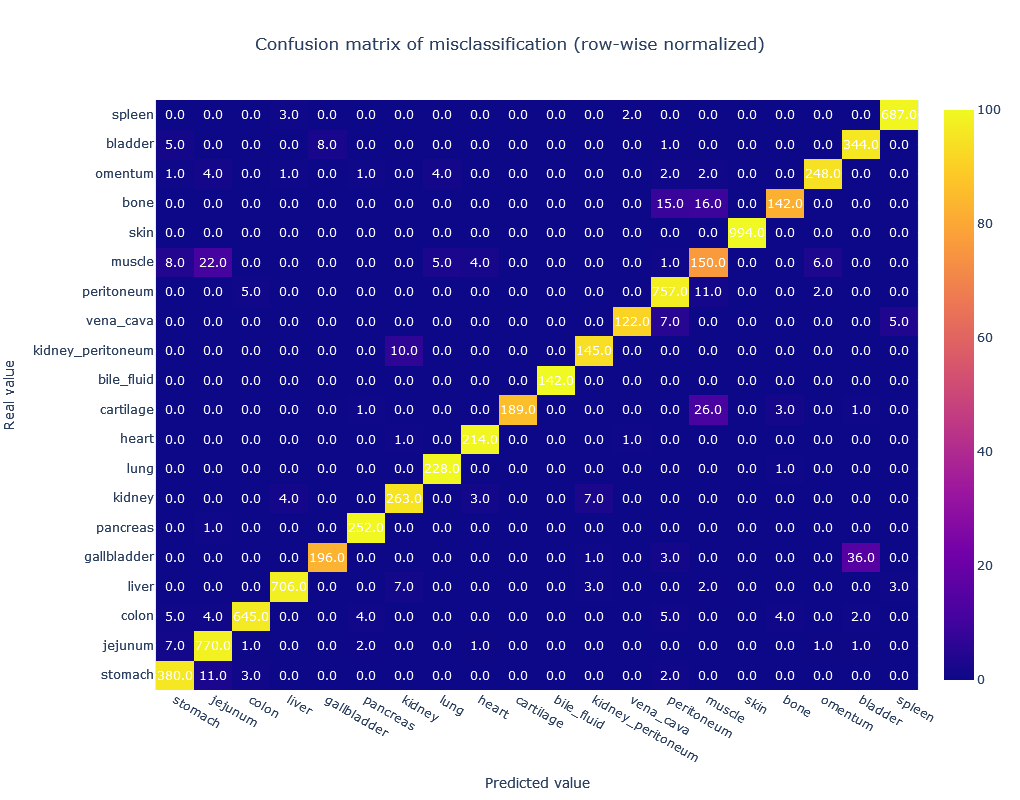

In [10]:
cm_total = np.sum(np.stack(df_val["confusion_matrix"].values), axis=0)
create_confusion_figure(cm_total, labels=mapping.label_names())

## Testing

In [11]:
agg = MetricAggregationClassification(run_dir / "test_table.pkl.xz", config, metrics=["accuracy", "confusion_matrix"])
df_test = agg.subject_metrics()
df_test

,subject_name,accuracy,confusion_matrix
0,P086,0.897975,"[[56, 2, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0..."
1,P087,0.980322,"[[79, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
2,P089,0.941641,"[[52, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
3,P091,1.000000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,P092,0.983769,"[[67, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0..."
5,P093,0.974740,"[[64, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,P095,0.921645,"[[46, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
7,P096,0.932363,"[[30, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


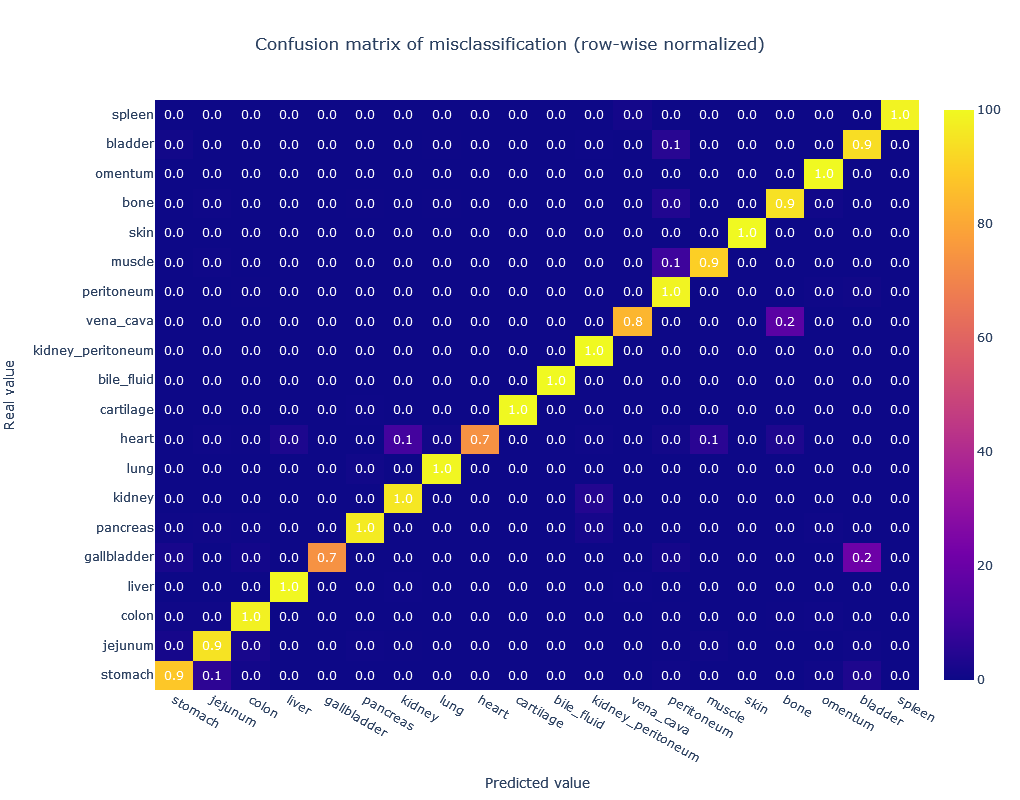

In [12]:
cm_rel, cm_std = normalize_grouped_cm(np.stack(df_test["confusion_matrix"].values))
create_confusion_figure(cm_rel, labels=mapping.label_names())

### Recall/Sensitivity

In [13]:
np.trace(cm_rel) / cm_rel.shape[0]

0.9392771641779486

In [14]:
rows = []
for i, row_test in df_test.iterrows():
    cm = row_test["confusion_matrix"]
    for j in range(cm.shape[0]):
        rowsum = np.sum(cm[j, :])
        if rowsum > 0:
            sensitivity = cm[j, j] / rowsum
            rows.append([row_test.subject_name, mapping.index_to_name(j), sensitivity])

df_sensitivity = pd.DataFrame(rows, columns=["subject_name", "organ", "sensitivity"])
df_sensitivity

,subject_name,organ,sensitivity
0,P086,stomach,0.800000
1,P086,small_bowel,0.961538
2,P086,colon,1.000000
3,P086,liver,1.000000
4,P086,gallbladder,0.217391
...,...,...,...
145,P096,skin,1.000000
146,P096,bone,0.984375
147,P096,omentum,1.000000
148,P096,bladder,0.733333


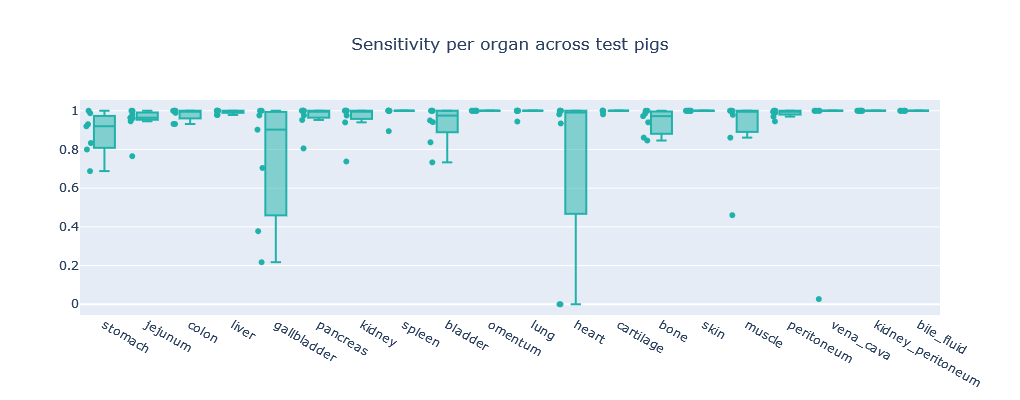

In [15]:
fig = go.Figure()
for organ in sort_labels(mapping.label_names()):
    values = df_sensitivity.query("organ == @organ")["sensitivity"].values
    pigs = df_sensitivity.query("organ == @organ")["subject_name"].values
    fig.add_trace(go.Box(y=values, name=organ, hovertext=pigs, boxpoints="all", marker_color="lightseagreen"))

fig.layout.height = 400
fig.layout.width = 1000
fig.update_layout(title_x=0.5, title_text="Sensitivity per organ across test pigs")
fig.update_layout(showlegend=False)

### Ensembling

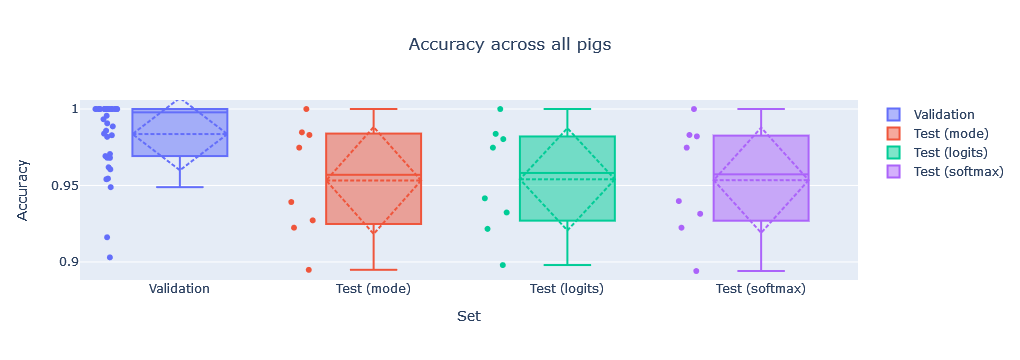

In [16]:
fig = go.Figure()
fig.add_trace(go.Box(y=df_val["accuracy"].values, boxmean="sd", boxpoints="all", name="Validation"))
fig.add_trace(
    go.Box(y=agg.subject_metrics("mode")["accuracy"].values, boxmean="sd", boxpoints="all", name="Test (mode)")
)
fig.add_trace(
    go.Box(y=agg.subject_metrics("logits")["accuracy"].values, boxmean="sd", boxpoints="all", name="Test (logits)")
)
fig.add_trace(
    go.Box(y=agg.subject_metrics("softmax")["accuracy"].values, boxmean="sd", boxpoints="all", name="Test (softmax)")
)
fig.update_layout(title_x=0.5, title_text="Accuracy across all pigs")
fig.update_layout(xaxis_title="Set", yaxis_title="Accuracy")